### 7/19 
Current Accuracy rank:<br>
1. xgboost
2. gru
3. knn
- Looking for ways to used dbscan for classification*<br>
- Need more data to check classification accuracy in gru, knn, xgboost<br>
[Click to navigate](#current_focus)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

<a id='current_focus'></a>
### Minecraft State Classification

- Task 1. Randomly moving or jumping around in any direction (wandering) - `0.0`

- Task 2. Simply mining with any tool user wants (mining) `1.0`

- Task 3. Continuously building blocks of user's choice, could be a simple N x N shape (building) `2.0`

In [ ]:
# checks the recently collected dataset

dir_name = 'minecraft-state'

directory = os.getcwd() + '/new_dataset/' + dir_name + '/'
files = os.listdir(directory)

for filename in files:
    if '.csv' in filename:
        df = pd.read_csv(directory + filename)
#         print(df.head())
        print('{}, shape = ({})'.format(filename, df.shape))

subjecta-building-1.csv, shape = ((14136, 5))
subjecta-mining-1.csv, shape = ((14129, 5))
subjecta-wandering-1.csv, shape = ((14136, 5))
subjectb-building-1.csv, shape = ((14136, 5))
subjectb-mining-1.csv, shape = ((14147, 5))
subjectb-wandering-1.csv, shape = ((14136, 5))
subjectc-building-1.csv, shape = ((14150, 5))
subjectc-mining-1.csv, shape = ((14158, 5))
subjectc-wandering-1.csv, shape = ((14150, 5))


In [ ]:
import EEG_feature_extraction as efe
from EEG_generate_training_matrix import gen_training_matrix

# Edit filename (from new dataset folder) here
filename = 'minecraft-state'
new_dir = os.getcwd() + '/new_dataset/' + filename

print('Generating matrix from: {}'.format(new_dir))

outfile_path = os.getcwd() + '/final_dataset/' + filename + '.csv'

gen_training_matrix(new_dir, outfile_path, [])

Generating matrix from: C:\Users\peanu\Desktop\EEG_Classification/new_dataset/minecraft-state
Using file subjecta-building-1.csv
resulting vector shape for the file (108, 989)
Using file subjecta-mining-1.csv
resulting vector shape for the file (108, 989)
Using file subjecta-wandering-1.csv
resulting vector shape for the file (108, 989)
Using file subjectb-building-1.csv
resulting vector shape for the file (108, 989)
Using file subjectb-mining-1.csv
resulting vector shape for the file (108, 989)
Using file subjectb-wandering-1.csv
resulting vector shape for the file (108, 989)
Using file subjectc-building-1.csv
resulting vector shape for the file (108, 989)
Using file subjectc-mining-1.csv
resulting vector shape for the file (108, 989)
Using file subjectc-wandering-1.csv
resulting vector shape for the file (109, 989)
FINAL_MATRIX (973, 989)


In [3]:
filename = 'minecraft-state'

outfile_path = os.getcwd() + '/' + filename + '.csv'

df = pd.read_csv(outfile_path)
print(df['Label'].value_counts())
print('df shape: {}'.format(df.shape))
df

0.0    325
1.0    324
2.0    324
Name: Label, dtype: int64
df shape: (973, 989)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,lag1_mean_q1_2,lag1_mean_q1_3,lag1_mean_q2_0,lag1_mean_q2_1,lag1_mean_q2_2,lag1_mean_q2_3,lag1_mean_d_q1q2_0,lag1_mean_d_q1q2_1,lag1_mean_d_q1q2_2,lag1_mean_d_q1q2_3,lag1_mean_d_q1q3_0,lag1_mean_d_q1q3_1,lag1_mean_d_q1q3_2,lag1_mean_d_q1q3_3,lag1_mean_d_q1q4_0,lag1_mean_d_q1q4_1,lag1_mean_d_q1q4_2,lag1_mean_d_q1q4_3,lag1_mean_d_q2q3_0,lag1_mean_d_q2q3_1,lag1_mean_d_q2q3_2,lag1_mean_d_q2q3_3,lag1_mean_d_q2q4_0,lag1_mean_d_q2q4_1,lag1_mean_d_q2q4_2,lag1_mean_d_q2q4_3,lag1_std_0,lag1_std_1,lag1_std_2,lag1_std_3,...,freq_345_3,freq_355_3,freq_365_3,freq_375_3,freq_385_3,freq_395_3,freq_405_3,freq_416_3,freq_426_3,freq_436_3,freq_446_3,freq_456_3,freq_466_3,freq_476_3,freq_486_3,freq_517_3,freq_527_3,freq_537_3,freq_547_3,freq_557_3,freq_568_3,freq_578_3,freq_588_3,freq_598_3,freq_608_3,freq_618_3,freq_628_3,freq_639_3,freq_649_3,freq_659_3,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3,Label
0,-32.154915,-38.225452,-28.599344,-30.135834,6.803057,5.225593,1.649192,4.854986,-32.617780,-42.057168,-27.494704,-28.341291,-38.417774,-39.651406,-31.302407,-36.674256,5.799994,-2.405762,3.807703,8.332965,-1.851539,-7.721907,1.856150,1.179339,-5.824278,-5.200734,-1.254586,-2.397548,-7.651533,-5.316145,-1.951553,-7.153626,-11.624272,-2.794973,-5.062289,-10.730513,28.816915,18.593763,18.849429,35.752691,...,0.017202,0.016973,0.015967,0.022701,0.012251,0.015062,0.014078,0.022655,0.024247,0.002683,0.001663,0.036528,0.022276,0.025368,0.028232,0.029194,0.018445,0.029154,0.054118,0.048679,0.067469,0.095822,0.131813,0.418110,0.505693,0.160135,0.070051,0.049708,0.051429,0.013104,0.037577,0.026346,0.038671,0.044081,0.030746,0.012169,0.016596,0.012201,0.013379,2.0
1,-35.142831,-39.223388,-27.766906,-34.991569,2.398636,-2.235254,2.033929,4.384926,-43.317410,-39.067399,-29.355277,-41.195990,-29.550449,-37.169430,-28.227501,-33.277651,-13.766961,-1.897969,-1.127776,-7.918339,-0.781135,1.680851,-2.052391,0.943831,-17.740532,0.877098,-3.143729,-17.491791,12.985826,3.578820,-0.924615,8.862170,-3.973571,2.775067,-2.015953,-9.573453,30.021050,14.937625,12.898872,30.251720,...,0.007380,0.038325,0.019385,0.015440,0.004249,0.022031,0.020526,0.027515,0.012452,0.035881,0.021636,0.024455,0.023262,0.021025,0.007073,0.005408,0.018415,0.026102,0.026433,0.020608,0.022332,0.033131,0.070544,0.096422,0.272728,0.119921,0.063087,0.014464,0.004120,0.029663,0.004435,0.022129,0.013027,0.003004,0.015533,0.022746,0.012299,0.007075,0.024237,1.0
2,-32.548954,-40.783730,-30.661788,-33.093772,-2.622299,-2.152502,0.231816,0.484548,-31.462627,-38.090302,-29.296960,-30.340881,-31.018898,-41.282098,-32.219464,-36.252391,-0.443729,3.191796,2.922504,5.911510,1.671443,1.437924,1.974689,0.278147,3.104404,6.040073,0.542249,4.684337,2.115172,-1.753872,-0.947815,-5.633362,3.548133,2.848276,-2.380255,-1.227173,28.077509,18.307230,18.275841,35.205481,...,0.028623,0.031915,0.014750,0.015222,0.029838,0.014958,0.022739,0.009980,0.037242,0.014858,0.010897,0.030828,0.007305,0.002504,0.003168,0.004004,0.019790,0.006940,0.029879,0.035646,0.053611,0.049915,0.096609,0.195696,0.668912,0.144535,0.107760,0.053032,0.036844,0.046871,0.034697,0.019636,0.024048,0.024585,0.026056,0.032212,0.037245,0.022134,0.021206,2.0
3,-39.512475,-44.579129,-29.252835,-36.577075,-3.722855,-2.184927,1.894596,-1.376476,-29.774390,-39.678152,-31.772935,-34.454201,-45.320424,-47.194956,-28.668721,-37.285719,15.546035,7.516804,-3.104214,2.831519,22.084739,10.177976,-6.257862,10.160243,1.390212,1.919026,-0.750368,-4.344621,6.538704,2.661171,-3.153648,7.328725,-14.155822,-5.597778,2.353846,-7.176140,43.222238,20.904041,17.702335,43.669562,...,0.010473,0.016065,0.016210,0.003900,0.010854,0.016232,0.013264,0.003876,0.003773,0.016036,0.010098,0.002983,0.007249,0.010898,0.012914,0.011434,0.003980,0.015132,0.002280,0.007132,0.020270,0.0

In [4]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_inputs(df)

In [30]:
# Test Accuracy: 54.74%
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

dropout_1 = tf.keras.layers.Dropout(0.5)(expand_dims)

gru = tf.keras.layers.GRU(256, return_sequences=True)(dropout_1)

flatten = tf.keras.layers.Flatten()(gru)

dropout_2 = tf.keras.layers.Dropout(0.25)(flatten)

outputs = tf.keras.layers.Dense(3, activation='softmax')(dropout_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 988)]             0         
_________________________________________________________________
tf.expand_dims_7 (TFOpLambda (None, 988, 1)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 988, 1)            0         
_________________________________________________________________
gru_7 (GRU)                  (None, 988, 256)          198912    
_________________________________________________________________
flatten_5 (Flatten)          (None, 252928)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 252928)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 7587

In [31]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=16,
    epochs=20,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=5,
    #         restore_best_weights=True
    #     )
    # ]
)

Epoch 1/20
34/34 [==============================] - 56s 2s/step - loss: 5.0309 - accuracy: 0.3842 - val_loss: 3.3345 - val_accuracy: 0.4964
Epoch 2/20
34/34 [==============================] - 55s 2s/step - loss: 1.8543 - accuracy: 0.5074 - val_loss: 4.5761 - val_accuracy: 0.4891
Epoch 3/20
34/34 [==============================] - 55s 2s/step - loss: 1.3937 - accuracy: 0.5901 - val_loss: 2.7327 - val_accuracy: 0.4745
Epoch 4/20
34/34 [==============================] - 55s 2s/step - loss: 1.1044 - accuracy: 0.6213 - val_loss: 1.6498 - val_accuracy: 0.5839
Epoch 5/20
34/34 [==============================] - 55s 2s/step - loss: 1.1556 - accuracy: 0.6360 - val_loss: 1.3561 - val_accuracy: 0.5912
Epoch 6/20
34/34 [==============================] - 55s 2s/step - loss: 1.0212 - accuracy: 0.6526 - val_loss: 1.2861 - val_accuracy: 0.6569
Epoch 7/20
34/34 [==============================] - 55s 2s/step - loss: 0.7970 - accuracy: 0.6912 - val_loss: 1.7156 - val_accuracy: 0.5547
Epoch 8/20
34/34 [==

Test Accuracy: 82.877%


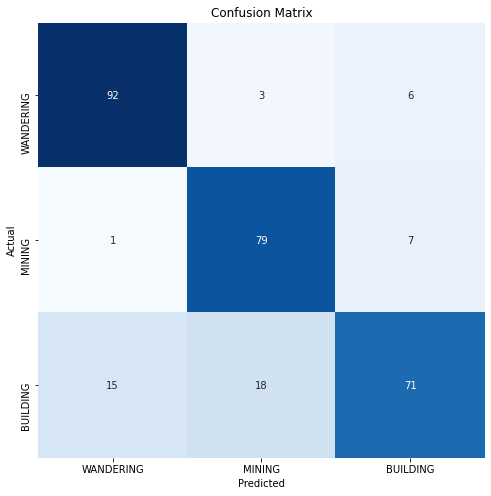

Classification Report:
----------------------
               precision    recall  f1-score   support

   WANDERING       0.85      0.91      0.88       101
      MINING       0.79      0.91      0.84        87
    BUILDING       0.85      0.68      0.76       104

    accuracy                           0.83       292
   macro avg       0.83      0.83      0.83       292
weighted avg       0.83      0.83      0.83       292



In [27]:
# Epoch = 50, batch_size = 16
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

label_mapping = {'WANDERING': 0, 'MINING': 1, 'BUILDING': 2}
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

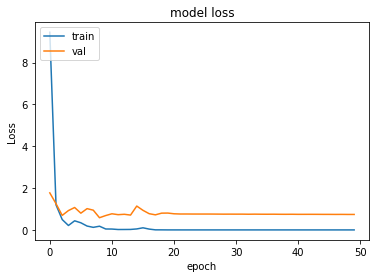

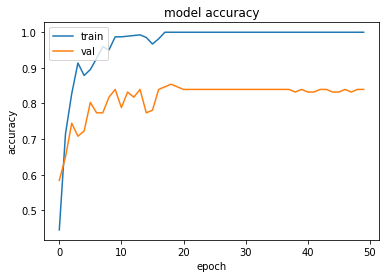

In [26]:
# Epoch = 50, batch_size = 16
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Test Accuracy: 78.767%


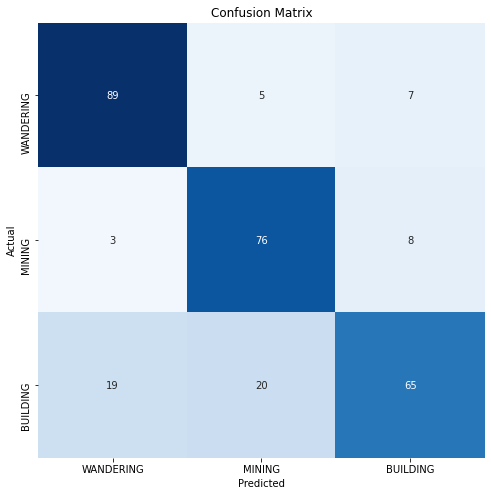

Classification Report:
----------------------
               precision    recall  f1-score   support

   WANDERING       0.80      0.88      0.84       101
      MINING       0.75      0.87      0.81        87
    BUILDING       0.81      0.62      0.71       104

    accuracy                           0.79       292
   macro avg       0.79      0.79      0.78       292
weighted avg       0.79      0.79      0.78       292



In [22]:
# Epoch = 50, batch_size = 32
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

label_mapping = {'WANDERING': 0, 'MINING': 1, 'BUILDING': 2}
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

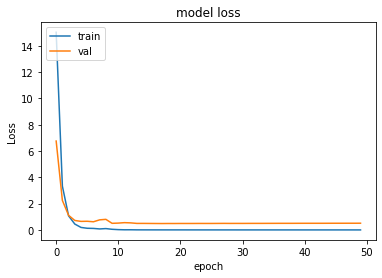

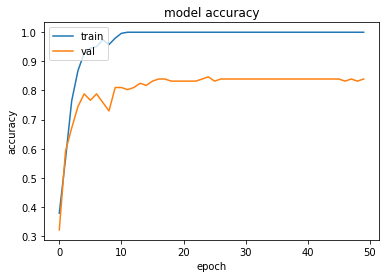

In [23]:
# Epoch = 50, batch_size = 32
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Test Accuracy: 77.055%


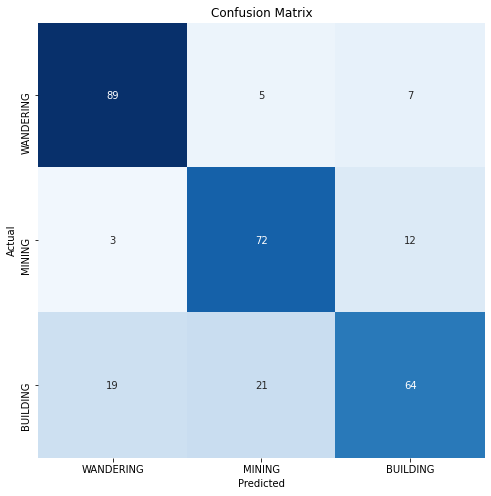

Classification Report:
----------------------
               precision    recall  f1-score   support

   WANDERING       0.80      0.88      0.84       101
      MINING       0.73      0.83      0.78        87
    BUILDING       0.77      0.62      0.68       104

    accuracy                           0.77       292
   macro avg       0.77      0.77      0.77       292
weighted avg       0.77      0.77      0.77       292



In [14]:
# Epoch = 20, batch_size = 32
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

label_mapping = {'WANDERING': 0, 'MINING': 1, 'BUILDING': 2}
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

### KNN Algorithm

In [ ]:
from sklearn import preprocessing

filename = 'minecraft-state'

outfile_path = os.getcwd() + '/final_dataset/' + filename + '.csv'

df = pd.read_csv(outfile_path)
print(df['Label'].value_counts())
print('df shape: {}'.format(df.shape))
df

0.0    325
2.0    324
1.0    324
Name: Label, dtype: int64
df shape: (973, 989)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,...,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3,Label
0,-32.154915,-38.225452,-28.599344,-30.135834,6.803057,5.225593,1.649192,4.854986,-32.617780,-42.057168,...,0.037577,0.026346,0.038671,0.044081,0.030746,0.012169,0.016596,0.012201,0.013379,2.0
1,-35.142831,-39.223388,-27.766906,-34.991569,2.398636,-2.235254,2.033929,4.384926,-43.317410,-39.067399,...,0.004435,0.022129,0.013027,0.003004,0.015533,0.022746,0.012299,0.007075,0.024237,1.0
2,-32.548954,-40.783730,-30.661788,-33.093772,-2.622299,-2.152502,0.231816,0.484548,-31.462627,-38.090302,...,0.034697,0.019636,0.024048,0.024585,0.026056,0.032212,0.037245,0.022134,0.021206,2.0
3,-39.512475,-44.579129,-29.252835,-36.577075,-3.722855,-2.184927,1.894596,-1.376476,-29.774390,-39.678152,...,0.028276,0.022365,0.031524,0.014410,0.021651,0.021817,0.010353,0.011237,0.007726,2.0
4,-9.200765,163.049569,120.176561,-0.160824,42.486742,415.572946,301.298434,52.962178,-28.159193,-41.692288,...,0.003679,0.009024,0.005311,0.001758,0.003479,0.005200,0.007017,0.002784,0.003826,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,-22.166039,-34.030333,-26.453365,-23.609843,5.130053,0.350995,0.574369,7.962462,-21.720876,-36.235050,...,0.024663,0.018919,0.021896,0.019785,0.027643,0.021995,0.006676,0.024823,0.010953,0.0
969,-19.669118,-35.359204,-27.159941,-22.330722,-16.951093,-1.026881,1.026953,-17.099711,-10.006260,-32.865070,...,0.025038,0.020321,0.019798,0.017891,0.014547,0.008585,0.008694,0.006551,0.004816,0.0
970,26.812232,-598.593236,-674.365386,-468.112799,518.590663,116.055408,213.795310,990.246248,494.250502,-409.155657,...,0.022302,0.023809,0.014034,0.017585,0.026038,0.008745,0.027847,0.016975,0.021814,0.0
971,-26.429620,-34.773938,-27.886926,-27.678752,3.838017,-3.782865,-1.324432,4.283563,-28.534060,-30.811800,...,0.028103,0.007661,0.007353,0.007109,0.011065,0.004962,0.014220,0.008101,0.002246,0.0


Test Accuracy: 86.986%


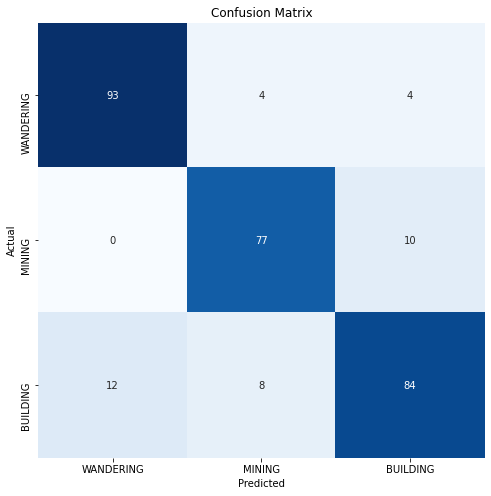

Classification Report:
----------------------
               precision    recall  f1-score   support

   WANDERING       0.89      0.92      0.90       101
      MINING       0.87      0.89      0.88        87
    BUILDING       0.86      0.81      0.83       104

    accuracy                           0.87       292
   macro avg       0.87      0.87      0.87       292
weighted avg       0.87      0.87      0.87       292



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy: {:.3f}%".format(metrics.accuracy_score(y_test, y_pred)*100))

label_mapping = {'WANDERING': 0, 'MINING': 1, 'BUILDING': 2}
# y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

### XGBoost Algorithm

C:\Users\peanu\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:14] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\peanu\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Test Accuracy: 93.151%


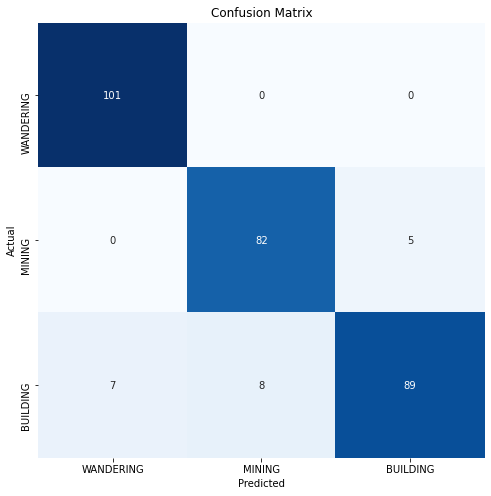

Classification Report:
----------------------
               precision    recall  f1-score   support

   WANDERING       0.94      1.00      0.97       101
      MINING       0.91      0.94      0.93        87
    BUILDING       0.95      0.86      0.90       104

    accuracy                           0.93       292
   macro avg       0.93      0.93      0.93       292
weighted avg       0.93      0.93      0.93       292



In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

model = XGBClassifier()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Test Accuracy: {:.3f}%".format(metrics.accuracy_score(y_test, y_pred)*100))

label_mapping = {'WANDERING': 0, 'MINING': 1, 'BUILDING': 2}
# y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

### Mental State Classification (989 cols)
*Used Bluemuse*
- Task 1. Put the participant in a comfortable position while listening to low temp music. (relaxed) - `0.0`

- Task 2. Put the participant in a comfortable position. (neutral) `1.0`

- Task 3. Play tricky cups. (concentrating) `2.0`

In [ ]:
filename = 'mental-state-989.csv'
df = pd.read_csv(os.getcwd() + "/final_dataset/" + filename)

print('{} shape: {}'.format(filename, df.shape))
df

mental_state shape: (2479, 989)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_q1_0,lag1_mean_q1_1,...,freq_669_3,freq_679_3,freq_689_3,freq_699_3,freq_709_3,freq_720_3,freq_730_3,freq_740_3,freq_750_3,Label
0,25.781648,33.836367,-92.769629,19.187957,-1.542262,0.197462,-119.561133,2.032654,21.596272,33.965587,...,0.000230,0.000351,0.000547,0.000381,0.000350,0.000453,0.000442,0.000325,0.000209,2.0
1,29.357891,26.792566,417.203910,19.472121,-38.797263,-16.897194,-29.368531,-9.055370,44.647424,40.893307,...,0.001671,0.000740,0.001122,0.000521,0.000624,0.000439,0.001249,0.000727,0.000801,2.0
2,28.451926,31.076434,72.231301,14.245938,-13.225057,-0.614138,-28.331698,-8.858742,31.450289,30.692883,...,0.000748,0.000569,0.000327,0.000197,0.000833,0.000909,0.000699,0.001165,0.000616,2.0
3,21.282184,19.985184,16.220094,39.787312,1.847866,0.670216,-1.820355,20.220724,21.404679,20.777411,...,0.000990,0.005644,0.006891,0.010546,0.009583,0.011158,0.008853,0.004551,0.002287,1.0
4,20.431516,28.982168,27.540246,19.960398,2.491458,-6.020503,-1.071166,2.655259,16.295039,32.658163,...,0.001659,0.014379,0.014492,0.002949,0.004575,0.008305,0.007202,0.006957,0.009836,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2474,15.762328,19.113555,23.696867,7.568395,-6.503336,6.867187,-11.955396,-16.519912,19.838319,14.333094,...,0.008537,0.008941,0.004102,0.003156,0.003659,0.010179,0.004591,0.013817,0.004536,0.0
2475,34.675582,34.200645,-57.624820,-4.825609,7.382353,2.324416,-1.341208,-4.178625,26.383597,28.782987,...,0.003324,0.003593,0.001702,0.003121,0.002686,0.001645,0.001770,0.001038,0.001973,2.0
2476,29.813809,29.623031,-86.503988,7.532121,-19.581287,-0.628400,133.947160,-2.049096,45.484851,32.163999,...,0.000754,0.000508,0.000263,0.000701,0.000797,0.001096,0.000388,0.000529,0.001079,2.0
2477,59.453973,17.944332,-10.164238,42.568211,-1.300655,-19.993690,-54.331696,12.947622,55.203380,40.228490,...,0.003332,0.003557,0.004063,0.001662,0.002665,0.002353,0.003976,0.001660,0.003229,2.0


In [ ]:
df['Label'].value_counts()

1.0    830
2.0    830
0.0    819
Name: Label, dtype: int64

In [ ]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = preprocess_inputs(df)

In [ ]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1245)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1245, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 1245, 256)         198912    
_________________________________________________________________
flatten (Flatten)            (None, 318720)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 956163    
Total params: 1,155,075
Trainable params: 1,155,075
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
44/44 [==============================] - 197s 4s/step - loss: 5.3855 - accuracy: 0.6119 - val_loss: 0.8193 - val_accuracy: 0.8444
Epoch 2/20
44/44 [==============================] - 197s 4s/step - loss: 0.5102 - accuracy: 0.8887 - val_loss: 0.5470 - val_accuracy: 0.8905
Epoch 3/20
44/44 [==============================] - 198s 5s/step - loss: 0.1434 - accuracy: 0.9469 - val_loss: 0.4480 - val_accuracy: 0.9193
Epoch 4/20
44/44 [==============================] - 192s 4s/step - loss: 0.1646 - accuracy: 0.9464 - val_loss: 0.6178 - val_accuracy: 0.9078
Epoch 5/20
44/44 [==============================] - 196s 4s/step - loss: 0.0668 - accuracy: 0.9742 - val_loss: 0.4044 - val_accuracy: 0.9280
Epoch 6/20
44/44 [==============================] - 171s 4s/step - loss: 0.0332 - accuracy: 0.9860 - val_loss: 0.4706 - val_accuracy: 0.9164
Epoch 7/20
44/44 [==============================] - 157s 4s/step - loss: 0.0365 - accuracy: 0.9859 - val_loss: 0.6989 - val_accuracy: 0.8761
Epoch 8/20
44

In [ ]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 94.758%


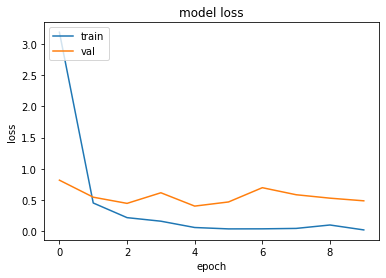

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

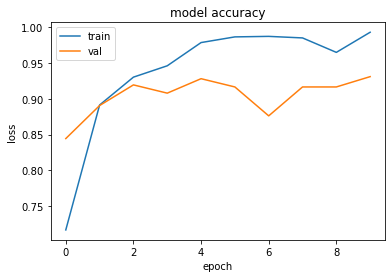

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

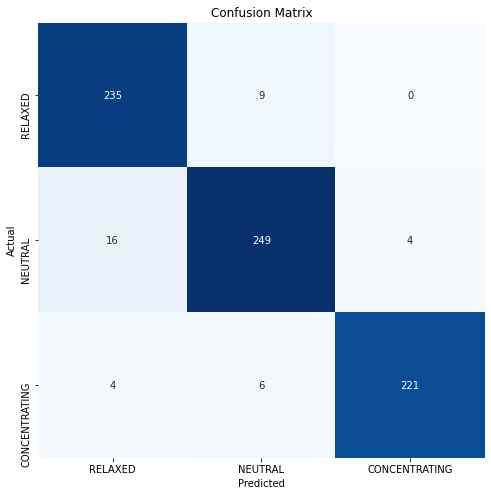

Classification Report:
----------------------
                precision    recall  f1-score   support

      RELAXED       0.92      0.96      0.94       244
      NEUTRAL       0.94      0.93      0.93       269
CONCENTRATING       0.98      0.96      0.97       231

     accuracy                           0.95       744
    macro avg       0.95      0.95      0.95       744
 weighted avg       0.95      0.95      0.95       744



In [ ]:
label_mapping = {'RELAXED': 0, 'NEUTRAL': 1, 'CONCENTRATING': 2}
y_pred = np.array(list(map(lambda x: np.argmax(x), model_989.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [ ]:
model_989.save('mental-state-gru.h5')

### Mental State Classification (1246 cols)
*Used Uvicmuse, which requires time conversion*

In [ ]:
import EEG_feature_extraction as efe
from EEG_generate_training_matrix import gen_training_matrix

path = os.getcwd() + '/dataset/original_data'
print('Generating matrix from {}'.format(path))
gen_training_matrix(path, 'ultimate-mental-state.csv', [])

Generating matrix from C:\Users\14056\Desktop\EEG_Classification/dataset/original_data
name-concentrating-1
name
concentrating
Using file name-concentrating-1.csv
resulting vector shape for the file (116, 1246)
subjecta-concentrating-1
subjecta
concentrating
Using file subjecta-concentrating-1.csv
resulting vector shape for the file (116, 1246)
subjecta-concentrating-2
subjecta
concentrating
Using file subjecta-concentrating-2.csv
resulting vector shape for the file (102, 1246)
subjecta-neutral-1
subjecta
neutral
Using file subjecta-neutral-1.csv
resulting vector shape for the file (116, 1246)
subjecta-neutral-2
subjecta
neutral
Using file subjecta-neutral-2.csv
resulting vector shape for the file (117, 1246)
subjecta-relaxed-1
subjecta
relaxed
Using file subjecta-relaxed-1.csv
resulting vector shape for the file (116, 1246)
subjecta-relaxed-2
subjecta
relaxed
Using file subjecta-relaxed-2.csv
resulting vector shape for the file (116, 1246)
subjectb-concentrating-1
subjectb
concentrati

C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


resulting vector shape for the file (84, 1246)
subjecte-concentrating-2
subjecte
concentrating
Using file subjecte-concentrating-2.csv
resulting vector shape for the file (55, 1246)
subjecte-neutral-1
subjecte
neutral
Using file subjecte-neutral-1.csv


C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


resulting vector shape for the file (79, 1246)
subjecte-neutral-2
subjecte
neutral
Using file subjecte-neutral-2.csv
resulting vector shape for the file (67, 1246)
subjecte-relaxed-1
subjecte
relaxed
Using file subjecte-relaxed-1.csv
resulting vector shape for the file (79, 1246)
subjecte-relaxed-2
subjecte
relaxed
Using file subjecte-relaxed-2.csv
resulting vector shape for the file (59, 1246)
FINAL_MATRIX (2902, 1246)


In [ ]:
df = pd.read_csv(os.getcwd() + '/final_dataset/ultimate-mental-state.csv')
print(df.shape)
df

(2902, 1246)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_d_h2h1_4,...,freq_669_4,freq_679_4,freq_689_4,freq_699_4,freq_709_4,freq_720_4,freq_730_4,freq_740_4,freq_750_4,Label
0,22.893855,30.412723,26.029590,14.249789,25.440242,-7.101478,-0.551013,3.735563,-9.372750,-5.329480,...,0.080341,4.965429e-02,2.612327e-02,0.030301,3.546703e-02,0.055508,6.329772e-02,7.144508e-02,0.046547,1.0
1,21.810559,24.108879,16.599691,-8.642172,24.791711,-1.305863,-4.731962,7.459924,-0.014769,0.940731,...,0.038109,6.765979e-02,3.109398e-02,0.070536,6.194057e-02,0.042393,3.474493e-02,6.307529e-02,0.022254,0.0
2,24.278617,25.215187,15.668879,17.013527,24.446484,7.218074,-4.339539,-0.363437,8.643985,0.059869,...,0.040962,5.655849e-02,3.648760e-02,0.047142,1.717881e-02,0.054836,4.089540e-03,5.307469e-02,0.016421,0.0
3,-30.250535,-32.649992,-30.521379,-21.618551,1.000000,4.143066,1.937572,1.357539,4.399786,0.000000,...,0.000000,1.784802e-19,1.778891e-19,0.000000,8.748897e-19,0.000000,1.763288e-19,1.761353e-19,0.000000,0.0
4,25.545121,29.661176,31.894648,24.271008,27.521129,-5.001456,-1.413423,0.453609,-2.489220,-2.833442,...,0.036457,2.638348e-02,2.963056e-02,0.061503,3.736360e-02,0.038793,2.425808e-03,3.386304e-02,0.019684,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897,13.708117,-337.991707,-113.306059,12.086828,23.874313,6.386891,512.648208,157.328791,7.050319,-1.243022,...,0.005520,6.885666e-03,5.299998e-03,0.006707,8.183844e-03,0.000943,1.164625e-02,2.777334e-03,0.012194,2.0
2898,23.416512,27.540238,42.179102,0.473047,29.109957,2.699743,-5.414999,-20.888921,3.923602,4.966026,...,0.096640,4.266555e-02,5.912066e-02,0.065626,4.408449e-02,0.053612,2.827642e-02,3.503184e-02,0.046586,0.0
2899,12.365332,23.424203,21.366109,5.121270,23.458484,-2.353175,-2.408318,1.432315,-1.196755,7.516107,...,0.034336,7.786022e-02,9.270427e-02,0.091345,6.086653e-02,0.059444,3.097274e-02,1.538622e-02,0.044919,0.0
2900,35.274484,24.690652,24.463645,-2.979277,19.861211,29.896946,7.296830,-16.680746,24.485432,4.279367,...,0.027575,6.029478e-02,4.728673e-02,0.029320,4.468241e-02,0.010577,3.627132e-02,3.688704e-02,0.078377,1.0


In [ ]:
df['Label'].value_counts()

1.0    976
2.0    969
0.0    957
Name: Label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_inputs(df)

### Best Model so far
- `ultimate_gru.h5` is trained on the ultimate-mental-state.csv, which includes jordan's dataset + my 3 different mental states, from my-mental-state folder
- 7/14 training a model solely on my-mental state achieved `Test Accuracy: 51.444%`

Epoch 50/50
51/51 [==============================] - 127s 2s/step - loss: 1.4701e-06 - accuracy: 1.0000 - val_loss: 2.8691 - val_accuracy: 0.9165

In [ ]:
model = tf.keras.models.load_model(os.getcwd() + '/saved_models/ultimate_gru.h5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1245)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1245, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 1245, 256)         198912    
_________________________________________________________________
flatten (Flatten)            (None, 318720)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 956163    
Total params: 1,155,075
Trainable params: 1,155,075
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 92.308%


### Testing `ultimate_gru.h5` on second_trials test set

In [ ]:
import EEG_feature_extraction as efe
from EEG_generate_training_matrix import gen_training_matrix

# Model is trained with subjecta-relaxed-1, subjecta-neutral-1, subjecta-concentrating-1, now testing with -2s
path = os.getcwd() + '/new_dataset/my-mental-state'
print(path)
gen_training_matrix(path, 'second_trials.csv', [])

C:\Users\14056\Desktop\EEG_Classification/new_dataset/my-mental-state
subjecta-concentrating-2
subjecta
concentrating
Using file subjecta-concentrating-2.csv


C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


resulting vector shape for the file (55, 1246)
subjecta-neutral-2
subjecta
neutral
Using file subjecta-neutral-2.csv
resulting vector shape for the file (67, 1246)
subjecta-relaxed-2
subjecta
relaxed
Using file subjecta-relaxed-2.csv
resulting vector shape for the file (59, 1246)
FINAL_MATRIX (181, 1246)


In [ ]:
test_set = pd.read_csv(os.getcwd() + '/final_dataset/second_trials.csv')
print(test_set.shape)
test_set

(181, 1246)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_d_h2h1_4,...,freq_669_4,freq_679_4,freq_689_4,freq_699_4,freq_709_4,freq_720_4,freq_730_4,freq_740_4,freq_750_4,Label
0,-35.860090,-32.758699,-30.435594,-6.793773,1.0,-0.296134,-0.178013,-0.684715,-4.524108,0.0,...,0.0,1.784802e-19,1.778891e-19,0.0,1.749779e-18,0.0,1.763288e-19,1.761353e-19,0.0,0.0
1,-32.087336,-33.014312,-32.142652,-15.238281,1.0,0.049073,1.424256,-3.328667,-4.123781,0.0,...,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.0
2,-30.350516,-31.803148,-27.876715,-22.692773,1.0,-5.603047,-3.226724,0.896780,-1.460413,0.0,...,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,1.0
3,-29.253828,-29.735555,-27.010766,-27.036820,1.0,2.915368,-1.152430,2.345665,6.133561,0.0,...,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,1.0
4,-30.815145,-29.436160,-30.952469,-26.436363,1.0,1.376743,-0.298479,-3.633788,-4.928824,0.0,...,0.0,1.784802e-19,1.778891e-19,0.0,1.749779e-18,0.0,1.763288e-19,1.761353e-19,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,-31.822188,-30.979160,-29.081332,-22.063312,1.0,0.363415,3.256240,-0.713420,6.941410,0.0,...,0.0,3.569605e-19,3.557783e-19,0.0,0.000000e+00,0.0,3.526575e-19,3.522706e-19,0.0,2.0
177,-33.605555,-30.603383,-28.749461,-27.953809,1.0,-10.206706,-0.548949,-1.102485,-4.705868,0.0,...,0.0,1.784802e-19,1.778891e-19,0.0,0.000000e+00,0.0,1.763288e-19,1.761353e-19,0.0,2.0
178,-31.791680,-30.311551,-30.822770,-25.910738,1.0,0.482865,3.474233,-3.460362,-10.696377,0.0,...,0.0,1.784802e-19,1.778891e-19,0.0,0.000000e+00,0.0,1.763288e-19,1.761353e-19,0.0,2.0
179,-28.942125,-29.798512,-29.670719,-24.277250,1.0,0.242189,2.100888,0.591966,-1.561784,0.0,...,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,2.0


In [ ]:
label_mapping = {'RELAXED': 0, 'NEUTRAL': 1, 'CONCENTRATING': 2}
test_set['Label'].value_counts()

1.0    67
0.0    59
2.0    55
Name: Label, dtype: int64

In [ ]:
def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_inputs(test_set)

In [ ]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 92.727%


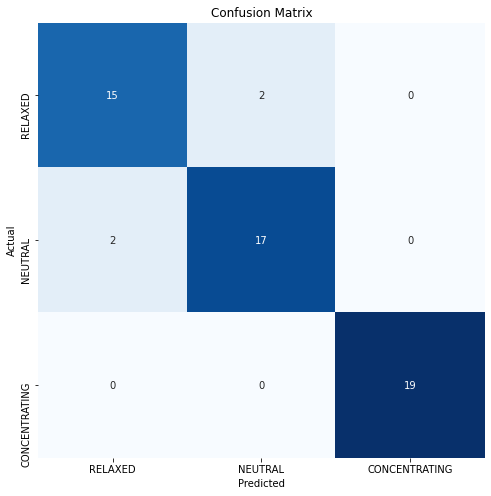

Classification Report:
----------------------
                precision    recall  f1-score   support

      RELAXED       0.88      0.88      0.88        17
      NEUTRAL       0.89      0.89      0.89        19
CONCENTRATING       1.00      1.00      1.00        19

     accuracy                           0.93        55
    macro avg       0.93      0.93      0.93        55
 weighted avg       0.93      0.93      0.93        55



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

### New Model (CNN)
- _Needs to be developed_

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(16, 16, 1)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(16, 16, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               1180160   
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)             

### Player Movement Classification
*Used Uvicmuse, which requires time conversion*
- Move mouse cursor left/right
- Say out loud "turn left/right"

In [ ]:
def reformat_timestamp_n_export(raw_dir, new_dir):
    
    # ~/new_dataset
    if not os.getcwd() + '/new_dataset':
        os.mkdir('/new_dataset')
        
    # ~/new_dataset/filename        
    if not os.path.exists(new_dir):
        os.mkdir(new_dir)
    
    files = os.listdir(raw_dir)
    for file in files:
        if '.csv' in file:
            print(file)
            df = pd.read_csv(raw_dir + '/' + file)
            for i in range(df['timestamps'].shape[0]):
                timestamp = df['timestamps'][i]/1000000.0
                df['timestamps'][i] = timestamp
            df.to_csv(new_dir + '/' + file, index=False)

In [ ]:
def new_dataset(filename):
    
    raw_dir = os.getcwd() + '/raw_dataset/' + filename
    new_dir = os.getcwd() + '/new_dataset/' + os.path.basename(raw_dir)

    print(raw_dir)
    print(new_dir)
    
    reformat_timestamp_n_export(raw_dir, new_dir)
    

new_dataset('left-right-commands')

C:\Users\14056\Desktop\EEG_Classification/raw_dataset/left-right-commands
C:\Users\14056\Desktop\EEG_Classification/new_dataset/left-right-commands
subjecta-neutral-1.csv
subjecta-neutral-2.csv
subjecta-neutral-3.csv
subjecta-neutral-4.csv
subjecta-relaxed-1.csv
subjecta-relaxed-2.csv
subjecta-relaxed-3.csv
subjecta-relaxed-4.csv


In [ ]:
import EEG_feature_extraction as efe
from EEG_generate_training_matrix import gen_training_matrix

filename = 'left-right-commands'

new_dir = os.getcwd() + '/new_dataset/' + filename

print('new_dir: {}'.format(new_dir))

outfile_path = os.getcwd() + '/final_dataset/left-right-commands.csv'

gen_training_matrix(new_dir, outfile_path, [])

new_dir: C:\Users\14056\Desktop\EEG_Classification/new_dataset/left-right-commands
subjecta-neutral-1
subjecta
neutral
Using file subjecta-neutral-1.csv


C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


resulting vector shape for the file (36, 1246)
subjecta-neutral-2
subjecta
neutral
Using file subjecta-neutral-2.csv
resulting vector shape for the file (27, 1246)
subjecta-neutral-3
subjecta
neutral
Using file subjecta-neutral-3.csv
resulting vector shape for the file (37, 1246)
subjecta-neutral-4
subjecta
neutral
Using file subjecta-neutral-4.csv
resulting vector shape for the file (27, 1246)
subjecta-relaxed-1
subjecta
relaxed
Using file subjecta-relaxed-1.csv
resulting vector shape for the file (25, 1246)
subjecta-relaxed-2
subjecta
relaxed
Using file subjecta-relaxed-2.csv
resulting vector shape for the file (28, 1246)
subjecta-relaxed-3
subjecta
relaxed
Using file subjecta-relaxed-3.csv
resulting vector shape for the file (27, 1246)
subjecta-relaxed-4
subjecta
relaxed
Using file subjecta-relaxed-4.csv
resulting vector shape for the file (34, 1246)
FINAL_MATRIX (241, 1246)


In [ ]:
df = pd.read_csv(outfile_path)
print(df.shape)
df

(241, 1246)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_d_h2h1_4,...,freq_669_4,freq_679_4,freq_689_4,freq_699_4,freq_709_4,freq_720_4,freq_730_4,freq_740_4,freq_750_4,Label
0,-31.457906,-30.981055,-31.833652,-19.327098,1.0,-0.231446,-1.185388,1.520611,3.041788,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
1,-30.813227,-30.223793,-32.409684,-27.732273,1.0,-1.702902,-0.707489,-0.314402,-4.929401,0.0,...,0.000000e+00,1.784802e-19,1.778891e-19,0.000000e+00,0.000000e+00,0.000000e+00,1.763288e-19,1.761353e-19,0.000000e+00,1.0
2,-29.691707,-31.871773,-30.965836,-21.820293,1.0,-2.439684,2.525205,-0.534982,3.348351,0.0,...,4.428933e-19,3.569605e-19,3.557783e-19,4.385062e-19,0.000000e+00,4.365796e-19,3.526575e-19,3.522706e-19,4.351439e-19,1.0
3,-41.259773,-42.781836,-23.645426,-16.824383,1.0,10.805844,7.373052,-0.184834,3.621097,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.748897e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
4,-30.794133,-30.057930,-29.823289,-18.792461,1.0,-1.256539,-0.504251,-1.749286,-3.490954,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,-28.553008,-30.857102,-31.024945,-24.326832,1.0,1.989263,2.475941,-1.367849,-2.637814,0.0,...,2.214467e-19,1.784802e-19,1.778891e-19,2.192531e-19,0.000000e+00,2.182898e-19,1.763288e-19,1.761353e-19,2.175720e-19,1.0
237,-29.329297,-28.133418,-31.219461,-25.101223,1.0,2.015593,1.694944,2.497096,-0.107641,0.0,...,0.000000e+00,1.784802e-19,1.778891e-19,0.000000e+00,0.000000e+00,0.000000e+00,1.763288e-19,1.761353e-19,0.000000e+00,0.0
238,-28.181059,-32.695781,-32.491676,-23.210742,1.0,1.555166,0.052040,1.348999,-0.535297,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.748897e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
239,-32.461152,-32.169336,-31.881332,-20.466867,1.0,2.355074,3.369953,-1.414278,-0.274663,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [ ]:
df['Label'].value_counts()

1.0    127
0.0    114
Name: Label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_inputs(df)

In [ ]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(2, activation='softmax')(flatten)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1245)]            0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 1245, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 1245, 256)         198912    
_________________________________________________________________
flatten (Flatten)            (None, 318720)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 637442    
Total params: 836,354
Trainable params: 836,354
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=16,
    epochs=50,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=5,
#             restore_best_weights=True
#         )
#     ]
)

Epoch 1/20
9/9 [==============================] - 19s 2s/step - loss: 6.9515 - accuracy: 0.6810 - val_loss: 9.7201 - val_accuracy: 0.4118
Epoch 2/20
9/9 [==============================] - 15s 2s/step - loss: 3.3334 - accuracy: 0.6400 - val_loss: 4.1281 - val_accuracy: 0.5882
Epoch 3/20
9/9 [==============================] - 14s 2s/step - loss: 0.7802 - accuracy: 0.8621 - val_loss: 2.5066 - val_accuracy: 0.5588
Epoch 4/20
9/9 [==============================] - 14s 2s/step - loss: 0.2021 - accuracy: 0.9387 - val_loss: 2.5601 - val_accuracy: 0.5588
Epoch 5/20
9/9 [==============================] - 14s 2s/step - loss: 0.0899 - accuracy: 0.9480 - val_loss: 2.4179 - val_accuracy: 0.5588
Epoch 6/20
9/9 [==============================] - 14s 2s/step - loss: 0.0343 - accuracy: 1.0000 - val_loss: 2.3987 - val_accuracy: 0.5294
Epoch 7/20
9/9 [==============================] - 13s 1s/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 2.4129 - val_accuracy: 0.5588
Epoch 8/20
9/9 [==================

In [ ]:
# 1, 2, 3, 4 with no early stop
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 67.123%


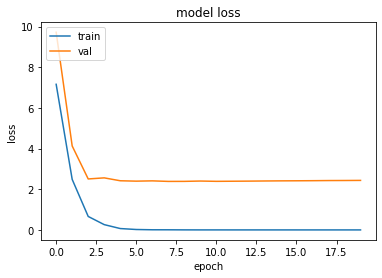

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

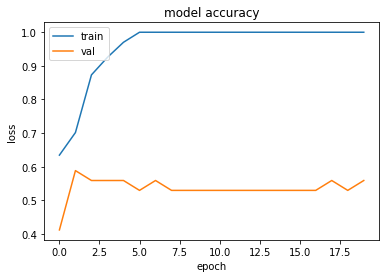

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Testing on the 5 second period dataset

In [ ]:
def new_dataset(filename):
    
    raw_dir = os.getcwd() + '/raw_dataset/' + filename
    new_dir = os.getcwd() + '/new_dataset/' + os.path.basename(raw_dir)

    print(raw_dir)
    print(new_dir)
    
    reformat_timestamp_n_export(raw_dir, new_dir)
    

new_dataset('left-right-commands-test')

C:\Users\14056\Desktop\EEG_Classification/raw_dataset/left-right-commands-test
C:\Users\14056\Desktop\EEG_Classification/new_dataset/left-right-commands-test
subjecta-neutral-1.csv
subjecta-neutral-2.csv
subjecta-relaxed-1.csv
subjecta-relaxed-2.csv


In [ ]:
import EEG_feature_extraction as efe
from EEG_generate_training_matrix import gen_training_matrix

filename = 'left-right-commands-test'
raw_dir = os.getcwd() + '/raw_dataset/' + filename
new_dir = os.getcwd() + '/new_dataset/' + os.path.basename(raw_dir)

print('new_dir: {}'.format(new_dir))

outfile_path = os.getcwd() + '/final_dataset/' + filename + '.csv'

gen_training_matrix(new_dir, outfile_path, [])

new_dir: C:\Users\14056\Desktop\EEG_Classification/new_dataset/left-right-commands-test
subjecta-neutral-1
subjecta
neutral
Using file subjecta-neutral-1.csv
resulting vector shape for the file (3, 1246)
subjecta-neutral-2
subjecta
neutral
Using file subjecta-neutral-2.csv
resulting vector shape for the file (4, 1246)
subjecta-relaxed-1
subjecta
relaxed
Using file subjecta-relaxed-1.csv


C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)
C:\Users\14056\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


resulting vector shape for the file (4, 1246)
subjecta-relaxed-2
subjecta
relaxed
Using file subjecta-relaxed-2.csv
resulting vector shape for the file (2, 1246)
FINAL_MATRIX (13, 1246)


In [ ]:
df = pd.read_csv(outfile_path)
print(df.shape)
df

(13, 1246)


,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_d_h2h1_0,lag1_mean_d_h2h1_1,lag1_mean_d_h2h1_2,lag1_mean_d_h2h1_3,lag1_mean_d_h2h1_4,...,freq_669_4,freq_679_4,freq_689_4,freq_699_4,freq_709_4,freq_720_4,freq_730_4,freq_740_4,freq_750_4,Label
0,-39.203629,-36.201477,-25.501270,-34.034078,1.0,-11.544008,-11.416060,6.542541,-19.546295,0.0,...,0.000000e+00,3.569605e-19,3.557783e-19,0.000000e+00,3.499559e-18,0.000000e+00,3.526575e-19,3.522706e-19,0.000000e+00,1.0
1,-31.720047,-30.111352,-27.295805,-26.313199,1.0,-0.727118,-2.904672,-6.141288,4.543294,0.0,...,0.000000e+00,3.569605e-19,3.557783e-19,0.000000e+00,1.749779e-18,0.000000e+00,3.526575e-19,3.522706e-19,0.000000e+00,0.0
2,-33.098230,-30.868543,-30.050273,-31.838281,1.0,-1.818106,1.478074,0.261959,3.405084,0.0,...,4.428933e-19,3.569605e-19,3.557783e-19,4.385062e-19,0.000000e+00,4.365796e-19,3.526575e-19,3.522706e-19,4.351439e-19,0.0
3,-29.919484,-31.583820,-27.095539,-23.610484,1.0,4.730569,-0.022249,6.329404,2.069821,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
4,-33.895465,-31.002047,-28.532047,-31.477770,1.0,1.865990,2.782137,-0.110938,2.286421,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
5,-25.871766,-31.747852,-25.160320,-23.912680,1.0,0.733614,3.989520,-3.112306,5.147156,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.749779e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0
6,-18.909438,-22.560129,-34.648883,-21.023312,1.0,-15.682428,-9.118471,8.726644,-2.328777,0.0,...,0.000000e+00,8.924012e-20,8.894457e-20,0.000000e+00,0.000000e+00,0.000000e+00,8.816438e-20,8.806765e-20,0.000000e+00,1.0
7,-32.817836,-31.948090,-29.163379,-32.096859,1.0,-3.488311,-0.877012,1.462370,0.168540,0.0,...,0.000000e+00,1.784802e-19,1.778891e-19,0.000000e+00,1.749779e-18,0.000000e+00,1.763288e-19,1.761353e-19,0.000000e+00,0.0
8,-27.711855,-29.979719,-30.647262,-31.272594,1.0,33.696822,23.926246,-16.690961,23.552493,0.0,...,0.000000e+00,1.784802e-19,1.778891e-19,0.000000e+00,0.000000e+00,0.000000e+00,1.763288e-19,1.761353e-19,0.000000e+00,1.0
9,-32.823543,-30.580527,-29.386520,-32.193039,1.0,0.661964,-1.973669,-1.691101,-3.825741,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [ ]:
df['Label'].value_counts()

1.0    7
0.0    6
Name: Label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

def preprocess_inputs(df):
    df = df.copy()
    
    y = df['Label'].copy()
    X = df.drop('Label', axis=1).copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=123)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_inputs(df)

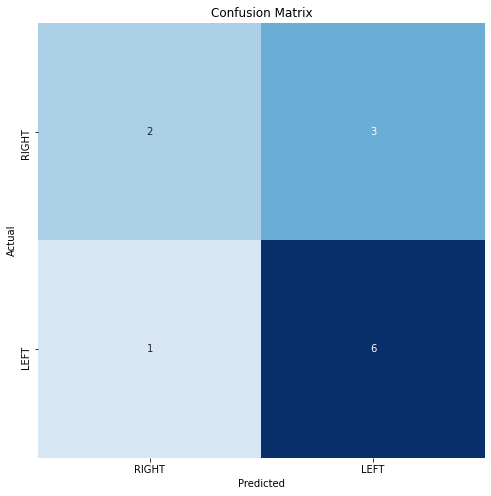

Classification Report:
----------------------
               precision    recall  f1-score   support

       RIGHT       0.67      0.40      0.50         5
        LEFT       0.67      0.86      0.75         7

    accuracy                           0.67        12
   macro avg       0.67      0.63      0.62        12
weighted avg       0.67      0.67      0.65        12



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

label_mapping = {'RIGHT': 0, 'LEFT': 1}

y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(2) + 0.5, label_mapping.keys())
plt.yticks(np.arange(2) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)